# Lecture 4. Document Distance

Natural Language Processing for Law and Social Science<br>
Benjamin Arold, ETH Zurich

In [1]:
# set random seed
import numpy as np
import seaborn as sns
np.random.seed(4)


In [2]:
# Setup
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
import pandas as pd
df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')
X = pd.read_pickle('X.pkl').toarray()
X_tfidf = pd.read_pickle('X_tfidf.pkl').toarray()

In [3]:
from gensim.utils import simple_preprocess
text0 = ' '.join(simple_preprocess(df['opinion_text'][0]))
text1 = ' '.join(simple_preprocess(df['opinion_text'][1]))

text1[:1000]

'justice stevens delivered the opinion of the court in most of the united states not including california the minimum price paid to dairy farmers producing raw milk is regulated pursuant to federal marketing orders those orders guarantee uniform price for the producers but through pooling mechanisms require the processors of different classes of dairy products to pay different prices thus for example processors of fluid milk pay premium price part of which goes into an equalization pool that provides partial subsidy for cheese manufacturers who pay net price that is lower than the farmers receive seewest lynn creamery inc healy ed ct the california legislature has adopted similar program to regulate the minimum prices paid by california processors to california producers in the cases before us today out of state producers are challenging the of amendment to that program they present us with two questions whether of the federal agriculture improvement and reform act of stat usc uscs exe

# Document Distance

## Text Re-Use

Notes on this implementation of the Smith-Waterman algorithm can be found [here](https://tiefenauer.github.io/blog/smith-waterman/#step-1-scoring-matrix)

In [34]:
import itertools
import numpy as np

def matrix(a, b, match_score=3, gap_cost=2):
    H = np.zeros((len(a) + 1, len(b) + 1), int)

    for i, j in itertools.product(range(1, H.shape[0]), range(1, H.shape[1])):
        match = H[i - 1, j - 1] + (match_score if a[i - 1] == b[j - 1] else - match_score)
        delete = H[i - 1, j] - gap_cost
        insert = H[i, j - 1] - gap_cost
        H[i, j] = max(match, delete, insert, 0)
    return H
def traceback(H, b, b_='', old_i=0):
    # flip H to get index of **last** occurrence of H.max() with np.argmax()
    H_flip = np.flip(np.flip(H, 0), 1)
    i_, j_ = np.unravel_index(H_flip.argmax(), H_flip.shape)
    i, j = np.subtract(H.shape, (i_ + 1, j_ + 1))  # (i, j) are **last** indexes of H.max()
    if H[i, j] == 0:
        return b_, j
    b_ = b[j - 1] + '-' + b_ if old_i - i > 1 else b[j - 1] + b_
    return traceback(H[0:i, 0:j], b, b_, i)
def smith_waterman(a, b, match_score=3, gap_cost=2):
    a, b = a.upper(), b.upper()
    H = matrix(a, b, match_score, gap_cost)
    b_, pos = traceback(H, b)
    return pos, pos + len(b_)

start, end = smith_waterman(text0[:1000], text1[:1000])

In [35]:
text0[start: end]

'justice ginsburg delivered the opinion of the co'

## Cosine Similarity

In [8]:
# compute pair-wise similarities between all documents in corpus"
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(X[:100])
print(sim.shape)

sim[:3,:3]

(100, 100)


array([[1.        , 0.16771115, 0.41233013],
       [0.16771115, 1.        , 0.25182999],
       [0.41233013, 0.25182999, 1.        ]])

In [9]:
# TF-IDF Similarity
tsim = cosine_similarity(X_tfidf[:100])
tsim[:3,:3]

array([[1.        , 0.08203256, 0.37870975],
       [0.08203256, 1.        , 0.12641009],
       [0.37870975, 0.12641009, 1.        ]])

## Jensen-Shannon Divergence

A walkthrough of its steps [here](https://cosinesimilarity.org/content/cosine-similarity-hypothesis-tests.html)

In [10]:
from scipy.stats import entropy #entropy(x, y)=sum(x*log(x/y))
def js(p, q):
    p /= p.sum()
    q /= q.sum()
    m = (p + q) / 2
    return (entropy(p, m) + entropy(q, m)) / 2
js(tsim[0],tsim[1])

0.0727544227193744

# Clustering

## K-means clustering

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.9,  
                        max_features=300,
                        stop_words='english',
                        ngram_range=(1,3))
X = vectorizer.fit_transform(df['opinion_text'])
words = vectorizer.get_feature_names_out()

X = X.todense()
X = X / X.sum(axis=1)
features = []
for i, word in enumerate(words):
    column = X[:,i]
    df['x_'+word] = np.ravel(column)
    features.append('x_'+word)
df.head()

,case_name,opinion_type,date_standard,authorship,x_republican,maj_judges,dissent_judges,topic_id,cite_count,opinion_text,...,x_time,x_title,x_trial,x_use,x_used,x_view,x_violation,x_way,x_year,x_years
0,ERICK CORNELL CLAY v. UNITED STATES,majority,2003-03-04,GINSBURG,0.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,2926.0,JUSTICE GINSBURG delivered the opinion of the ...,...,0.043578,0.002294,0.002294,0.000000,0.000000,0.002294,0.004587,0.002294,0.022936,0.000000
1,"HILLSIDE DAIRY INC., A&A DAIRY, L&S DAIRY, AND...",majority,2003-06-09,STEVENS,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['THOMAS, CLARENCE']",8.0,117.0,Justice Stevens delivered the opinion of the C...,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"CHARLES RUSSELL RHINES v. DOUGLAS WEBER, WARDEN",majority,2005-03-30,O'CONNOR,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,23364.0,Justice O'Connor delivered the opinion of the ...,...,0.007663,0.000000,0.000000,0.000000,0.000000,0.000000,0.001916,0.001916,0.015326,0.001916
4,STATE OF ALASKA v. UNITED STATES OF AMERICA,majority,2005-06-06,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['REHNQUIST, WILLIAM', 'SCALIA, ANTONIN', 'THO...",10.0,84.0,Justice Kennedy delivered the opinion of the C...,...,0.004664,0.046642,0.000000,0.002799,0.007463,0.013993,0.000000,0.003731,0.000933,0.003731
5,"REGINALD A. WILKINSON, DIRECTOR, OHIO DEPARTME...",majority,2005-06-13,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],4.0,4230.0,Justice Kennedy delivered the opinion of the C...,...,0.014164,0.000000,0.002833,0.002833,0.005666,0.001416,0.002833,0.000000,0.004249,0.001416


In [42]:
from sklearn.cluster import KMeans
num_clusters = 30
km = KMeans(n_clusters=num_clusters)

km.fit(np.asarray(X))
df['clusters'] = km.predict(np.asarray(X))
df[df['clusters']==3]['opinion_text']

69     Justice Kennedy delivered the opinion of the C...
108    Justice Ginsburg delivered the opinion of the ...
167    Justice Ginsburg delivered the opinion of the ...
217    Justice Souter delivered the opinion of the Co...
221    Justice Ginsburg delivered the opinion of the ...
294    Justice Scalia delivered the opinion of the Co...
341    Justice Thomas delivered the opinion of the Co...
429    Justice Souter delivered the opinion of the Co...
463    Justice Thomas delivered the opinion of the Co...
467    Justice Stevens delivered the opinion of the C...
489    Justice Scalia delivered the opinion of the Co...
609    Justice O'Connor delivered the opinion of the ...
670    JUSTICE SCALIA delivered the opinion of the Co...
681    JUSTICE GINSBURG delivered the opinion of the ...
688    CHIEF JUSTICEREHNQUIST delivered the opinion o...
719    JUSTICE O'CONNOR delivered the opinion of the ...
785    JUSTICE THOMAS delivered the opinion of the Co...
Name: opinion_text, dtype: obje

### Silhouette Score

Choose the optimal number of clusters. 

In [46]:
from sklearn.metrics import silhouette_score
silhouette_score(np.asarray(X), km.labels_)

0.05748619850318578

In [49]:
sil_scores = []
for n in range(2, num_clusters):
    km = KMeans(n_clusters=n)
    km.fit(np.asarray(X))
    sil_scores.append(silhouette_score(np.asarray(X), km.labels_))

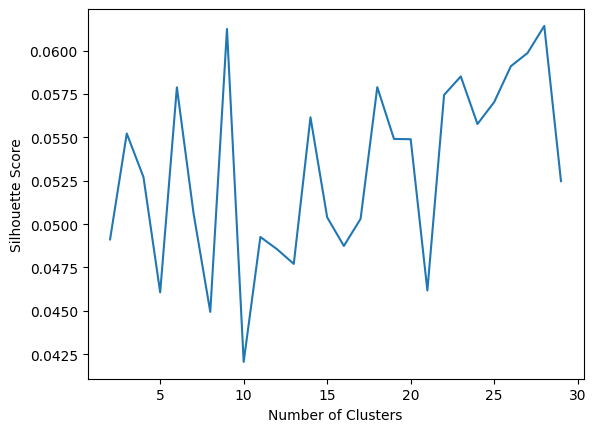

In [50]:
import matplotlib.pyplot as plt 
plt.plot(range(2, num_clusters), sil_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [51]:
opt_sil_score = max(sil_scores[5:20])
sil_scores.index(opt_sil_score)
opt_num_cluster = range(2, num_clusters)[sil_scores.index(opt_sil_score)]
print('The optimal number of clusters is %s' %opt_num_cluster)

The optimal number of clusters is 9


In [53]:
km = KMeans(n_clusters=opt_num_cluster)
km.fit(np.asarray(X))

df['cluster_mean'] = km.predict(np.asarray(X))
df[df['cluster_mean']==1]['opinion_text']


15     Justice Thomas delivered the opinion of the Co...
82     Justice Thomas delivered the opinion of the Co...
98     Justice O'Connor delivered the opinion of the ...
99     Justice Thomas delivered the opinion of the Co...
103    Justice Stevens delivered the opinion of the C...
129    Justice O'Connor delivered the opinion of the ...
130    Chief Justice Rehnquist delivered the opinion ...
172    Justice Scalia delivered the opinion of the Co...
198    Chief Justice Rehnquist delivered the opinion ...
207    CHIEF JUSTICE REHNQUIST delivered the opinion ...
212    Justice Scalia delivered the opinion of the Co...
223    Justice Scalia delivered the opinion of the Co...
288    Justice Stevens delivered the opinion of the C...
309    Justice Scalia delivered the opinion of the Co...
319    Justice Scalia delivered the opinion of the Co...
360    Justice Scalia delivered the opinion of the Co...
369    Justice Kennedy delivered the opinion of the C...
378    Justice Thomas delivered

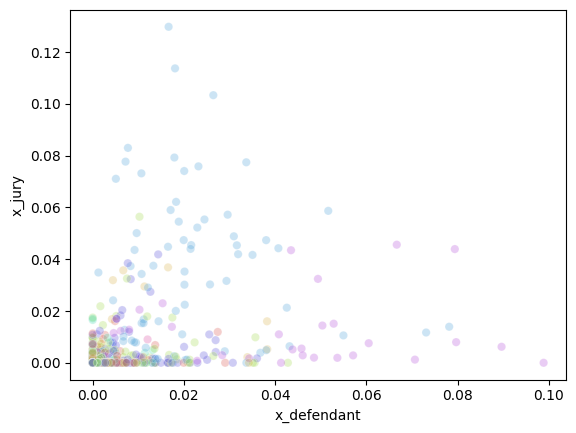

In [58]:
plot = sns.scatterplot(data = df, x = 'x_defendant', y ='x_jury', hue=df['cluster_mean'], palette=sns.color_palette("hls", opt_num_cluster), alpha=0.3)
plot.legend_.remove()
plt.show()


In [59]:
X

matrix([[0.        , 0.        , 0.00229358, ..., 0.00229358, 0.02293578,
         0.        ],
        [0.00331126, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.00191571, 0.01532567,
         0.00191571],
        ...,
        [0.00100503, 0.00201005, 0.0040201 , ..., 0.00201005, 0.00100503,
         0.00201005],
        [0.        , 0.00309119, 0.        , ..., 0.        , 0.        ,
         0.0015456 ],
        [0.00222469, 0.        , 0.00556174, ..., 0.00111235, 0.02113459,
         0.00333704]])

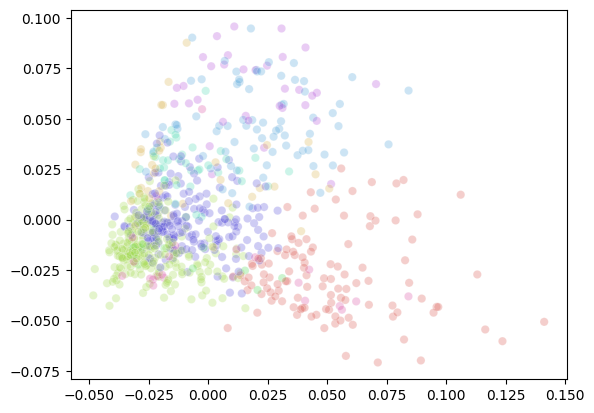

In [61]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
Xpca = pca.fit_transform( np.asarray(X))

plot = sns.scatterplot(
    x=Xpca[:,0], y=Xpca[:,1],
    hue=df['cluster_mean'],
    palette=sns.color_palette("hls", opt_num_cluster),
    alpha=0.3
)
plot.legend_.remove()

## K-Medoids

In [63]:
#!pip install scikit-learn-extra

from sklearn_extra.cluster import KMedoids

kmed = KMedoids(n_clusters=opt_num_cluster)
kmed.fit(np.asarray(X))
doc_clusters = kmed.labels_.tolist()

df['cluster_med'] = doc_clusters
df[df['cluster_med']==1]['opinion_text']

9      Justice Ginsburg delivered the opinion of the ...
11     Justice Ginsburg delivered the opinion of the ...
13     Justice Ginsburg delivered the opinion of the ...
31     Justice Scalia delivered the opinion of the Co...
43     Justice Alito delivered the opinion of the Cou...
                             ...                        
768    CHIEF JUSTICE REHNQUIST delivered the opinion ...
792    JUSTICE BREYER delivered the opinion of the Co...
804    JUSTICE STEVENS delivered the opinion of the C...
809    JUSTICE BREYER delivered the opinion of the Co...
811    JUSTICE KENNEDY delivered the opinion of the C...
Name: opinion_text, Length: 76, dtype: object

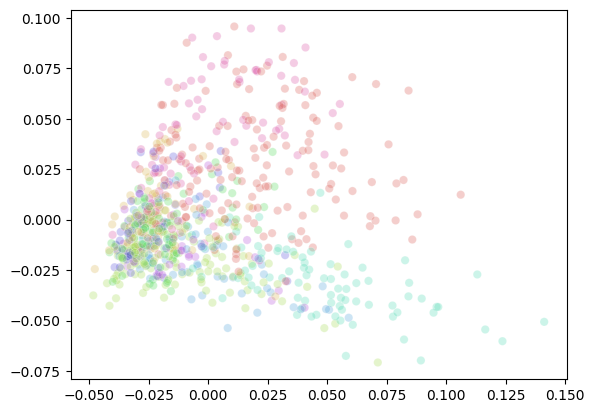

In [64]:
plot = sns.scatterplot(
    x=Xpca[:,0], y=Xpca[:,1],
    hue=df['cluster_med'],
    palette=sns.color_palette("hls", opt_num_cluster),
    alpha=0.3
)
plot.legend_.remove()

## DBSCAN

In [65]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.95, min_samples=10)
dbscan.fit(X_tfidf)
db_clusters = dbscan.labels_

df['cluster_db'] = db_clusters
df[df['cluster_db']==1]['opinion_text']

25     Justice Thomas delivered the opinion of the Co...
36     Justice Alito delivered the opinion of the Cou...
45     Justice Scalia delivered the opinion of the Co...
67     JUSTICE SCALIA delivered the opinion of the Co...
78     Justice Breyer announced the judgment of the C...
250    JUSTICE SCALIA delivered the opinion of the Co...
383    Justice Ginsburg delivered the opinion of the ...
392    Justice Souter delivered the opinion of the Co...
461    Justice Ginsburg delivered the opinion of the ...
468    Justice Thomas delivered the opinion of the Co...
484    Justice Scalia delivered the opinion of the Co...
580    JUSTICE BREYER delivered the opinion of the Co...
616    JUSTICE SOUTER delivered the opinion of the Co...
623    CHIEF JUSTICE REHNQUIST delivered the opinion ...
652    JUSTICE STEVENS delivered the opinion of the C...
764    JUSTICE GINSBURG delivered the opinion of the ...
Name: opinion_text, dtype: object

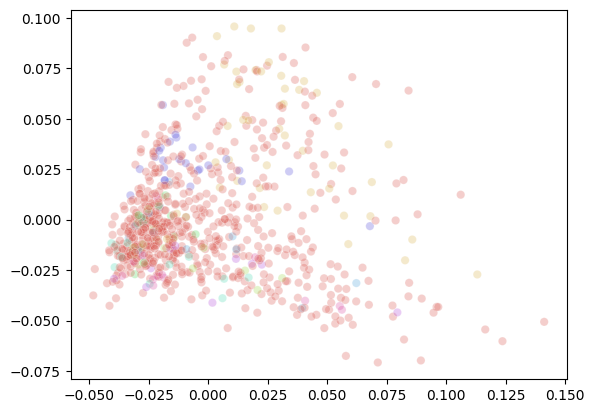

In [66]:
plot = sns.scatterplot(
    x=Xpca[:,0], y=Xpca[:,1],
    hue=df['cluster_db'],
    palette=sns.color_palette("hls", max(db_clusters)+2),
    alpha=0.3
)
plot.legend_.remove()

## Hierarchical Clustering

In [68]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=opt_num_cluster, affinity='euclidean', linkage='ward')
cluster.fit_predict(np.asarray(X))

clusters = dbscan.labels_

df['cluster_hie'] = clusters
df[df['cluster_hie']==1]['opinion_text']


25     Justice Thomas delivered the opinion of the Co...
36     Justice Alito delivered the opinion of the Cou...
45     Justice Scalia delivered the opinion of the Co...
67     JUSTICE SCALIA delivered the opinion of the Co...
78     Justice Breyer announced the judgment of the C...
250    JUSTICE SCALIA delivered the opinion of the Co...
383    Justice Ginsburg delivered the opinion of the ...
392    Justice Souter delivered the opinion of the Co...
461    Justice Ginsburg delivered the opinion of the ...
468    Justice Thomas delivered the opinion of the Co...
484    Justice Scalia delivered the opinion of the Co...
580    JUSTICE BREYER delivered the opinion of the Co...
616    JUSTICE SOUTER delivered the opinion of the Co...
623    CHIEF JUSTICE REHNQUIST delivered the opinion ...
652    JUSTICE STEVENS delivered the opinion of the C...
764    JUSTICE GINSBURG delivered the opinion of the ...
Name: opinion_text, dtype: object